In [1]:
!pip install numpy==1.23.0 --upgrade
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cuml 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
raft-dask 23.4.0 requires dask==2023.3.2, but you have dask 2023.4.0 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
lookback_data = np.load('/kaggle/input/bitcoin-price/loockback_data_selected.npy')
df = pd.read_csv('/kaggle/input/bitcoin-price/lags_dimensionless.csv')

In [3]:
lookback_data = lookback_data[1:]
df = df[1:]

In [4]:
log_return = df['log_return']
price = df['price']
df = df.drop(columns=['log_return', 'price'])

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
minmax_scaler = MinMaxScaler()
df = minmax_scaler.fit_transform(df)

In [6]:
import optuna
import tensorflow as tf
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from IPython.display import clear_output

In [7]:
def DrawGraph(predict, target, title=''):
    plt.figure(figsize=(16, 12))
    plt.title(title)
    sns.set_style('darkgrid')
    sns.lineplot(x=range(len(predict)), y=target, color='black', label='True Value')
    sns.lineplot(x=range(len(predict)), y=predict, color='lightblue', label='Predicted Value', alpha=0.7, err_style='band')
    plt.legend()
    plt.show()

In [8]:
def SplitData(data, target, train_fraction=0.8):
    train_size = int(train_fraction * data.shape[0])
    
    X_train = data[:train_size]
    y_train = target[:train_size]
    
    X_test = data[train_size:]
    y_test = target[train_size:]
    
    return X_train, X_test, y_train, y_test
    

In [9]:
def CountSlidingWindowResult(X, y, results, model, model_name):
    pred = model.forecast(X, y)
    
    result = pd.DataFrame(data={
        'RMSE': model.counMetric(mean_squared_error, y, squared=False),
        'MAPE': model.counMetric(mean_absolute_percentage_error, y) * 100,
        'MAE': model.counMetric(mean_absolute_percentage_error, y)
    },
    index=[model_name])
    results = results.append(result)

    print(f'RMSE for {model_name}: {model.counMetric(mean_squared_error, y, squared=False):.3f}')
    print(f'MAPE for {model_name}: {model.counMetric(mean_absolute_percentage_error, y) * 100:.3f}%')
    print(f'MAE for {model_name}: {model.counMetric(mean_absolute_percentage_error, y):.3f}')

    DrawGraph(pred, y, f'Results for {model_name}')

    return results

In [10]:
def CountModelResult(X_test, y_test, results, model, model_name):
    pred = model.predict(X_test)
    
    result = pd.DataFrame(data={
        'RMSE': mean_squared_error(pred, y_test, squared=False),
        'MAPE': mean_absolute_percentage_error(pred, y_test) * 100,
        'MAE': mean_absolute_error(pred, y_test)
    },
    index=[model_name])
    results = results.append(result)

    print(f'RMSE for {model_name}: {mean_squared_error(pred, y_test, squared=False):.3f}')
    print(f'MAPE for {model_name}: {mean_absolute_percentage_error(pred, y_test) * 100:.3f}%')
    print(f'MAE for {model_name}: {mean_absolute_error(pred, y_test):.3f}')

    DrawGraph(pred, y_test, f'Results for {model_name}')

    return results

In [11]:
import keras

class BaseModel:
    def __init__(self, n_layers=8, units=1024, n_epochs=300, activation='tanh', recurrent_activation='sigmoid', learning_rate=0.001, loss='mse', dropout=0.0, scaler=None):
        self.n_layers = n_layers
        self.units = units
        self.n_epochs = n_epochs
        self.activation = activation
        self.recurrent_activation = recurrent_activation
        self.learning_rate = learning_rate
        self.loss = loss
        self.dropout = dropout
        self.is_fitted = False

        if scaler is None:
            self.scaler = MinMaxScaler()
        else:
            self.scaler = scaler
        

    def compile(self):
        raise NotImplementedError('compile is not defined for BaseModel')
    
    def fit(self, X, y, n_epochs=None, shuffle=False, verbose=1):
        if n_epochs is None:
            n_epochs = self.n_epochs

        y = np.array(y).reshape(-1, 1)  # Convert y to a numpy array

        self.scaler.fit(y)  # Fit the scaler on the training data only

        scaled_y = self.scaler.transform(y)  # Apply the scaler to the target variable

        self.compile((X.shape[1], X.shape[2]))

        self.model.fit(X, scaled_y, epochs=n_epochs, shuffle=shuffle, verbose=verbose, batch_size=512)
        self.is_fitted = True

        return self
    
    def predict(self, X):
        assert self.is_fitted
        scaled_predictions = self.model.predict(X, verbose=0)  # Obtain scaled predictions
        predictions = self.scaler.inverse_transform(scaled_predictions)[:, 0]  # Invert the scaling
        return predictions
    
    def save(self, path):
        return self.model.save(path)
        
    def load(self, path):
        self.model = keras.models.load_model(path)
        self.is_fitted = True
        return self

In [12]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.optimizers import RMSprop
from keras.losses import Huber

class LSTMModel(BaseModel):
    def __init__(self, *args, **kwargs):
        super(LSTMModel, self).__init__(*args, **kwargs)

        assert(self.units % (2**(self.n_layers - 1)) == 0)

    def compile(self, input_shape):
        self.model = Sequential()

        units = self.units
        for iteration in range(self.n_layers - 1):
            if iteration == 0:
                self.model.add(Bidirectional(LSTM(
                    units=units,
                    input_shape=input_shape,
                    return_sequences=True
                    )))
            else:
                self.model.add(Bidirectional(LSTM(
                    units=units,
                    return_sequences=True
                    )))
            self.model.add(Dropout(self.dropout))
                
            units //= 2
        
        self.model.add(Bidirectional(LSTM(
            units=units,
            return_sequences=False
            )))
        self.model.add(Dropout(self.dropout))
        
        self.model.add(Dense(1, activation='linear'))

        self.model.compile(loss=Huber(), optimizer=RMSprop(learning_rate=self.learning_rate), metrics=['mae'])

        return self

In [13]:
from keras.layers import GRU

class GRUModel(BaseModel):
    def __init__(self, *args, **kwargs):
        super(GRUModel, self).__init__(*args, **kwargs)

        assert(self.units % (2**(self.n_layers - 1)) == 0)

    def compile(self, input_shape):
        self.model = Sequential()

        units = self.units
        for iteration in range(self.n_layers - 1):
            if iteration == 0:
                self.model.add(Bidirectional(GRU(
                    units=units,
                    input_shape=input_shape,
                    return_sequences=True
                    )))
            else:
                self.model.add(Bidirectional(GRU(
                    units=units,
                    return_sequences=True
                    )))
            self.model.add(Dropout(self.dropout))
                
            units //= 2
        
        self.model.add(Bidirectional(GRU(
            units=units,
            return_sequences=False
            )))
        self.model.add(Dropout(self.dropout))
        
        self.model.add(Dense(1, activation='linear'))

        self.model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=self.learning_rate), metrics=['mae'])

        return self

In [14]:
from keras.optimizers import SGD

class FNNModel(BaseModel):
    def __init__(self, *args, **kwargs):
        super(FNNModel, self).__init__(*args, **kwargs)

        assert(self.units % (2**(self.n_layers - 1)) == 0)

    def compile(self, input_shape):
        self.model = Sequential()

        units = self.units
        for iteration in range(self.n_layers):
            if iteration == 0:
                self.model.add(Dense(
                    units=units,
                    input_shape=(input_shape[0], None, input_shape[1]),
                    activation='linear'
                    ))
            else:
                self.model.add(Dense(
                    units=units,
                    activation='linear'
                    ))
            self.model.add(Dropout(self.dropout))
                
            units //= 2

        self.model.add(Dropout(self.dropout))
        
        self.model.add(Dense(1, activation='tanh'))

        self.model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=self.learning_rate), metrics=['mae'])

        return self
    
    def predict(self, X):
        assert self.is_fitted
        scaled_predictions = self.model.predict(X, verbose=0)  # Obtain scaled predictions
        predictions = self.scaler.inverse_transform(scaled_predictions[:,0,:])[:, 0]  # Invert the scaling
        return predictions

In [15]:
import numpy as np
from tqdm import tqdm


import numpy as np
from tqdm import tqdm


class SlidingWindowForecast:
    def __init__(self, model=None, forecast_interval=6, train_interval=24):
        self.setModel(model)
        self.forecast_interval = forecast_interval
        self.train_interval = train_interval
        self.prediction = None

    def setModel(self, model):
        self.model = model
        return self

    def forecast(self, data, target):
        assert (self.model is not None)

        prediction = np.array([None] * self.train_interval)

        for _ in tqdm(range((data.shape[0] - self.train_interval + self.forecast_interval - 1) // self.forecast_interval)):
            X_train = data[:self.train_interval]
            y_train = target[:self.train_interval]
            
            X_test = data[self.train_interval:self.train_interval +
                          self.forecast_interval]

            data = data[self.forecast_interval:]
            target = target[self.forecast_interval:]
            

            self.model.fit(X_train, y_train, verbose=0)
            prediction = np.concatenate(
                (prediction, self.model.predict(X_test)))

        self.prediction = prediction

        return prediction

    def predict(self, data, target):
        return self.forecast(data, target)

    def counMetric(self, metric, y, **kwargs):
        return metric(self.prediction[self.train_interval:], y[self.train_interval:], **kwargs)

    def latestForecast(self):
        assert (self.prediction is not None)
        return self.prediction


In [16]:
X_train, X_test, y_train, y_test = SplitData(lookback_data, log_return, 0.99)

#Hyperparameters for sliding window forecasting
fnn = FNNModel(n_layers=2, units=64, n_epochs=25, learning_rate=0.001, dropout=0.1)
gru = GRUModel(n_layers=2, units=32, n_epochs=25, learning_rate=0.0005, dropout=0.1)
lstm = LSTMModel(n_layers=2, units=32, n_epochs=25, learning_rate=0.0009, dropout=0.25)

In [17]:
results = pd.DataFrame()

100%|██████████| 394/394 [08:13<00:00,  1.25s/it]
/tmp/ipykernel_23/2558250014.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for FNN with sliding window for log return: 0.006
MAPE for FNN with sliding window for log return: 102.934%
MAE for FNN with sliding window for log return: 1.029


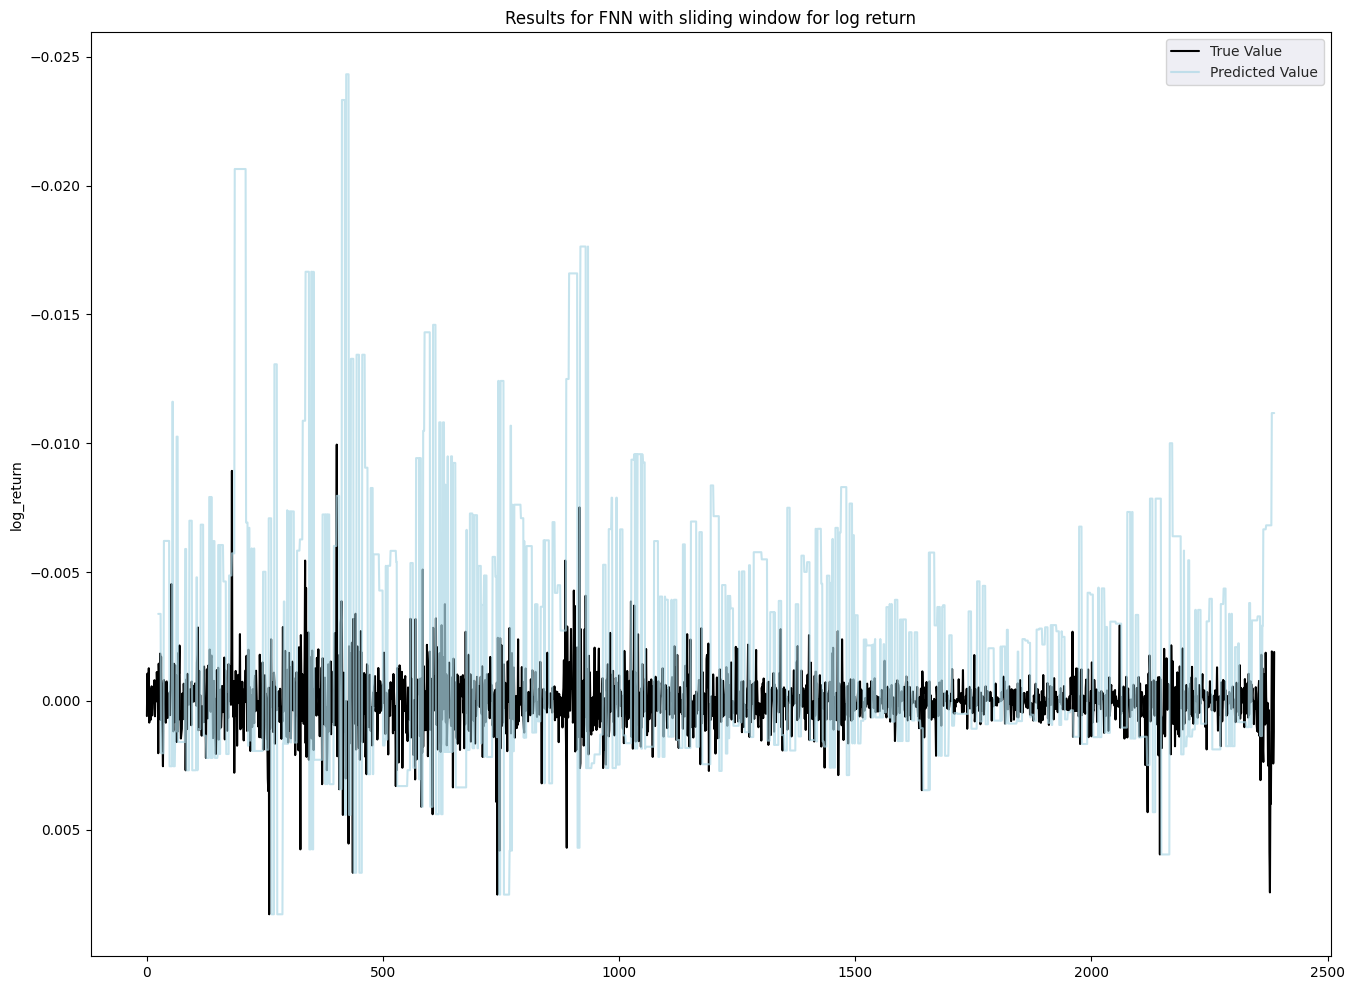

In [18]:
fnn_sw = SlidingWindowForecast().setModel(fnn)
clear_output()
results = CountSlidingWindowResult(X_test, y_test, results, fnn_sw, 'FNN with sliding window for log return')

100%|██████████| 394/394 [59:27<00:00,  9.05s/it]
/tmp/ipykernel_23/2558250014.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for GRU with sliding window for log return: 0.002
MAPE for GRU with sliding window for log return: 346.774%
MAE for GRU with sliding window for log return: 3.468


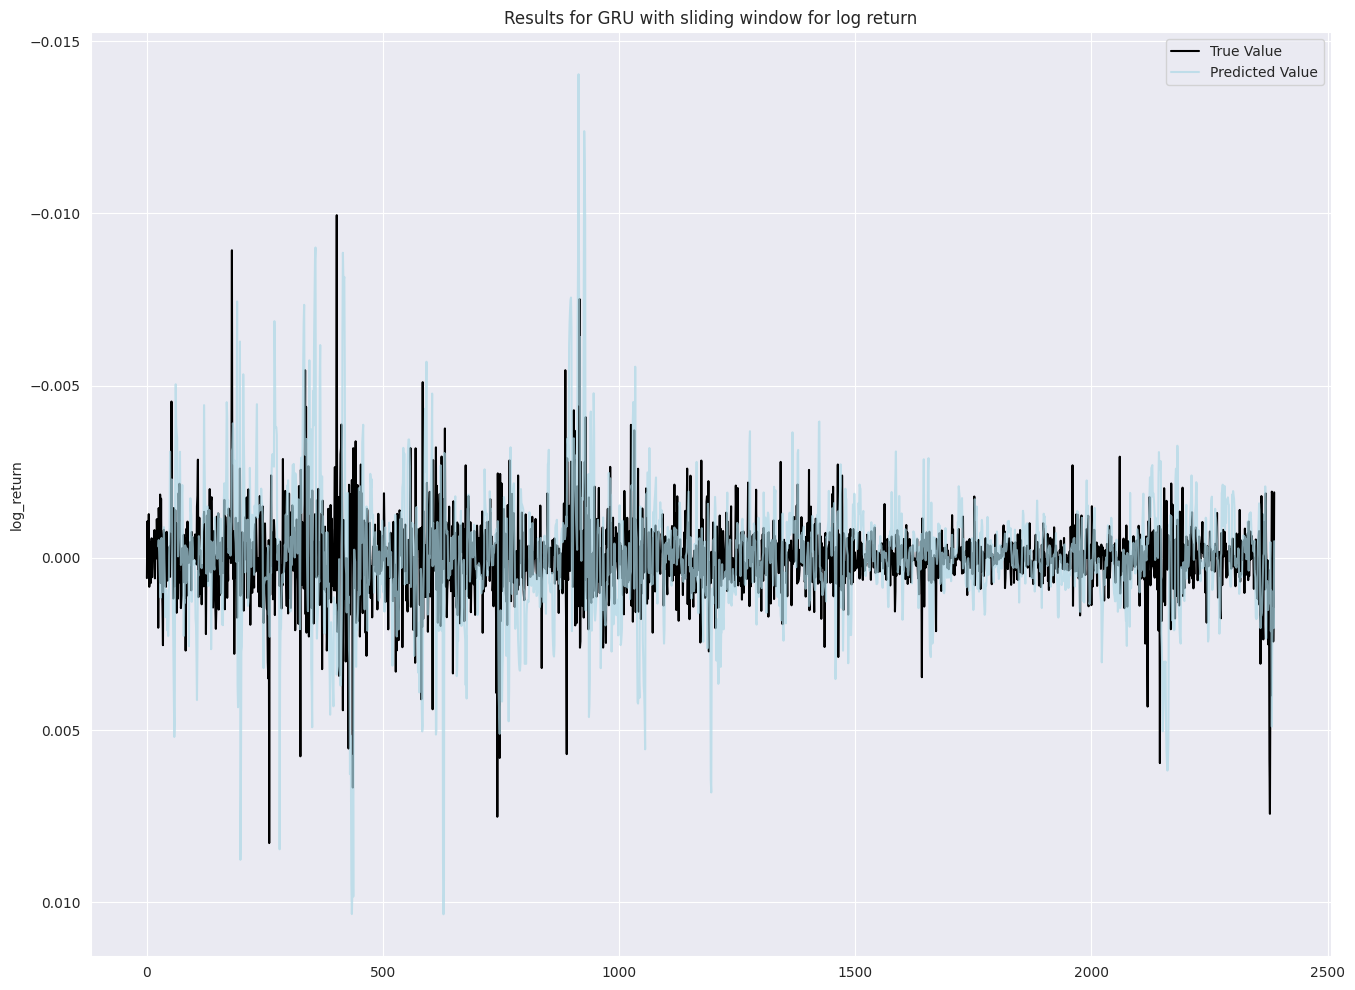

In [19]:
gru_sw = SlidingWindowForecast().setModel(gru)
clear_output()
results = CountSlidingWindowResult(X_test, y_test, results, gru_sw, 'GRU with sliding window for log return')

100%|██████████| 394/394 [1:02:17<00:00,  9.49s/it]
/tmp/ipykernel_23/2558250014.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for LSTM with sliding window for log return: 0.001
MAPE for LSTM with sliding window for log return: 893.806%
MAE for LSTM with sliding window for log return: 8.938


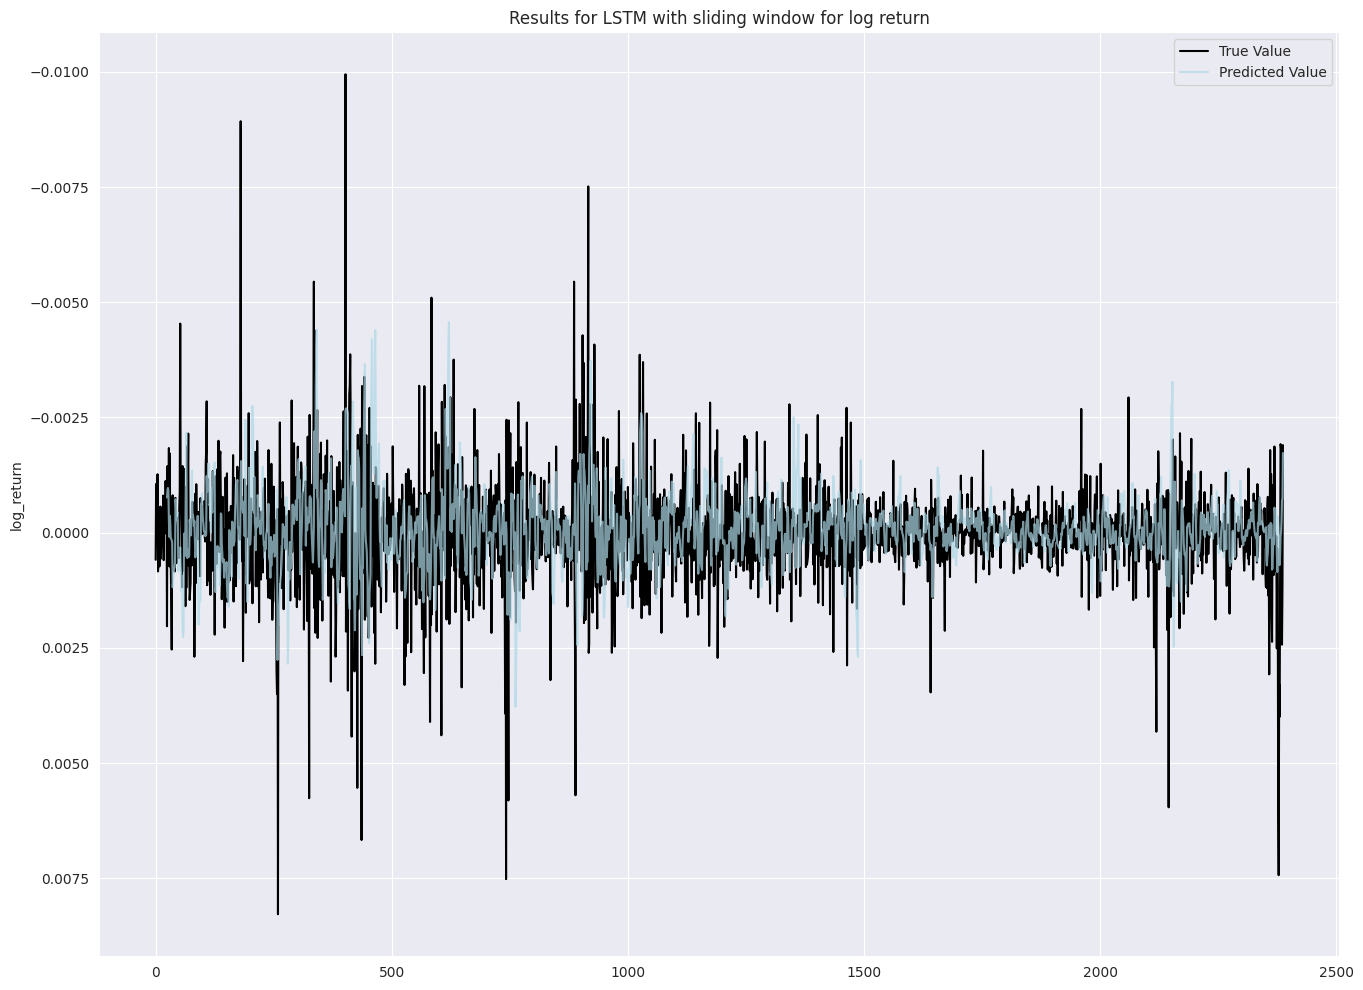

In [20]:
lstm_sw = SlidingWindowForecast().setModel(lstm)
clear_output()
results = CountSlidingWindowResult(X_test, y_test, results, lstm_sw, 'LSTM with sliding window for log return')

In [21]:
X_train, X_test, y_train, y_test = SplitData(lookback_data, log_return, train_fraction=0.99)

#Hyperparameters for regular forecasting
fnn = FNNModel(n_layers=3, units=256, n_epochs=100, learning_rate=0.001, dropout=0.25)
gru = GRUModel(n_layers=2, units=128, n_epochs=100, learning_rate=0.0005, dropout=0.25)
lstm = LSTMModel(n_layers=2, units=64, n_epochs=150, learning_rate=0.0009, dropout=0.25)

/tmp/ipykernel_23/1416441513.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for FNN for log return: 0.090
MAPE for FNN for log return: 99.989%
MAE for FNN for log return: 0.090


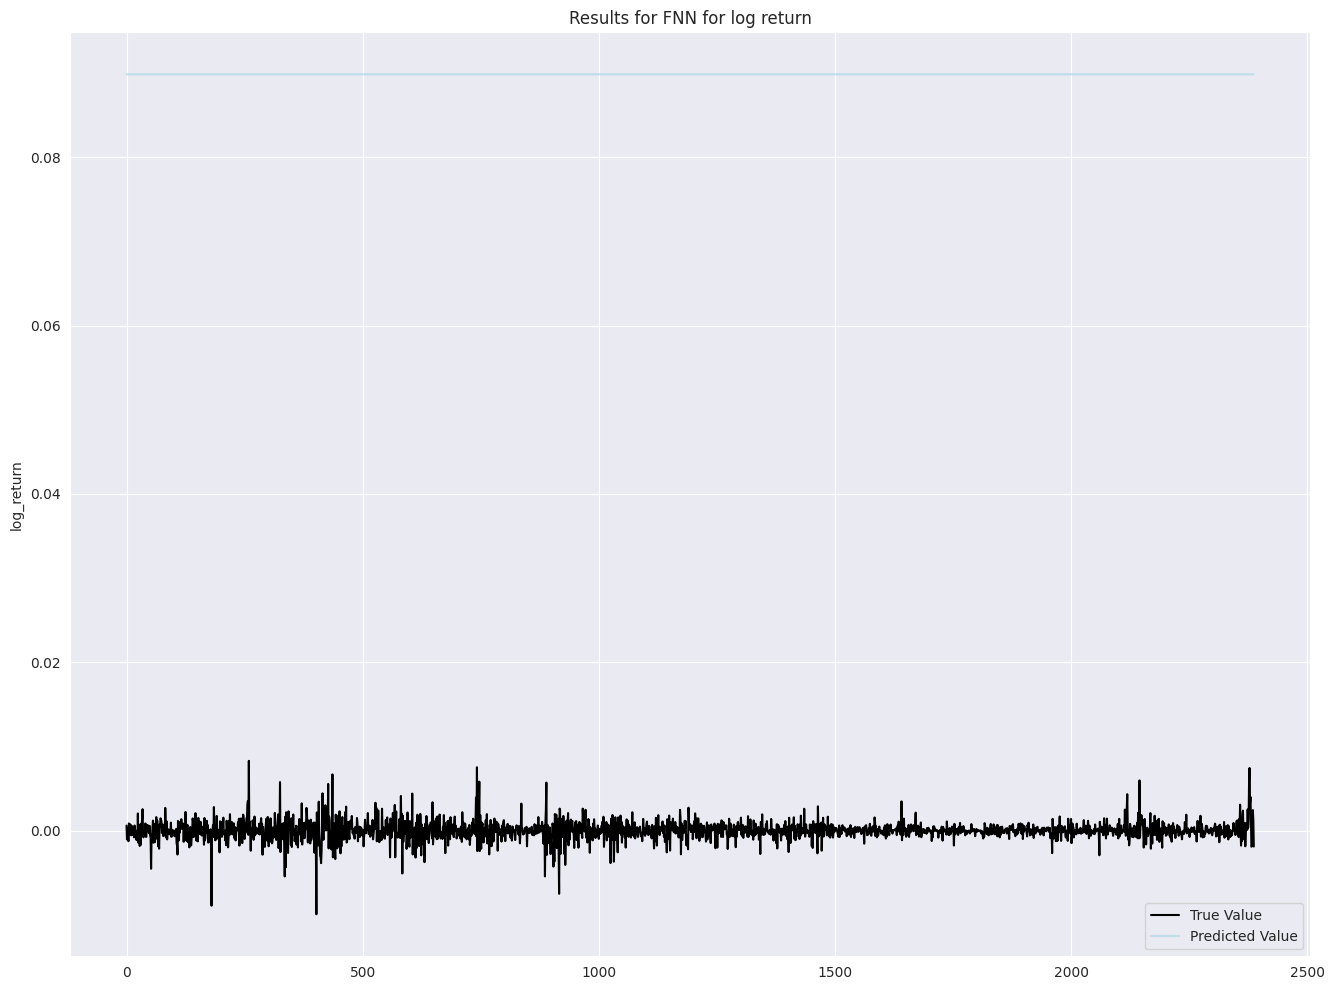

In [22]:
fnn.fit(X_train, y_train, n_epochs=30)
clear_output()
results = CountModelResult(X_test, y_test, results, fnn, 'FNN for log return')

/tmp/ipykernel_23/1416441513.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for LSTM for log return: 0.001
MAPE for LSTM for log return: 25298.259%
MAE for LSTM for log return: 0.001


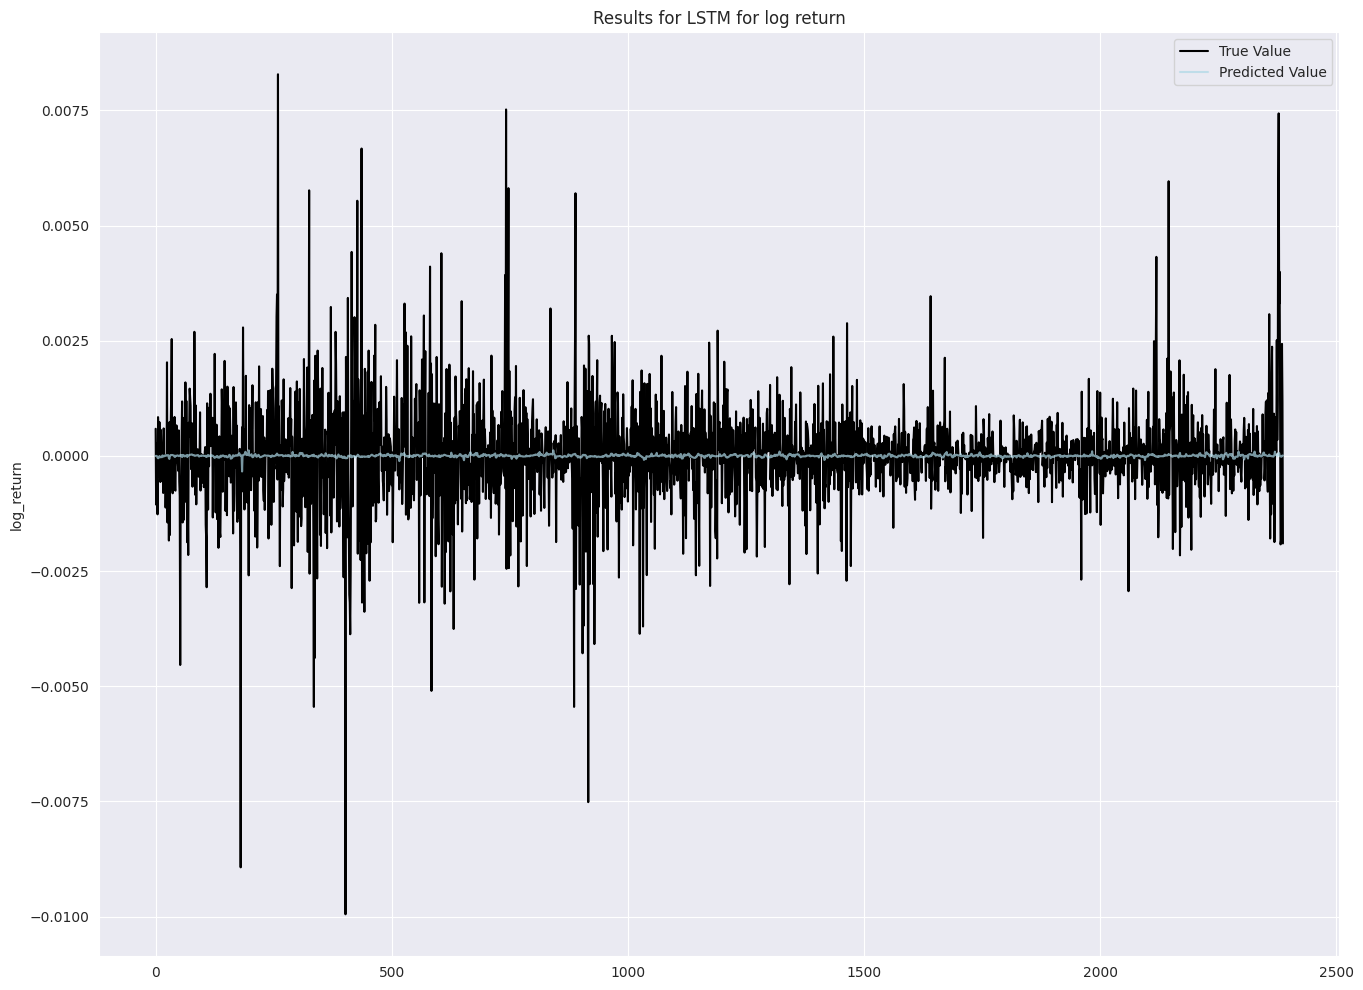

In [23]:
lstm.fit(X_train, y_train, n_epochs=30)
clear_output()
results = CountModelResult(X_test, y_test, results, lstm, 'LSTM for log return')

/tmp/ipykernel_23/1416441513.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for GRU for log return: 0.001
MAPE for GRU for log return: 16025.877%
MAE for GRU for log return: 0.001


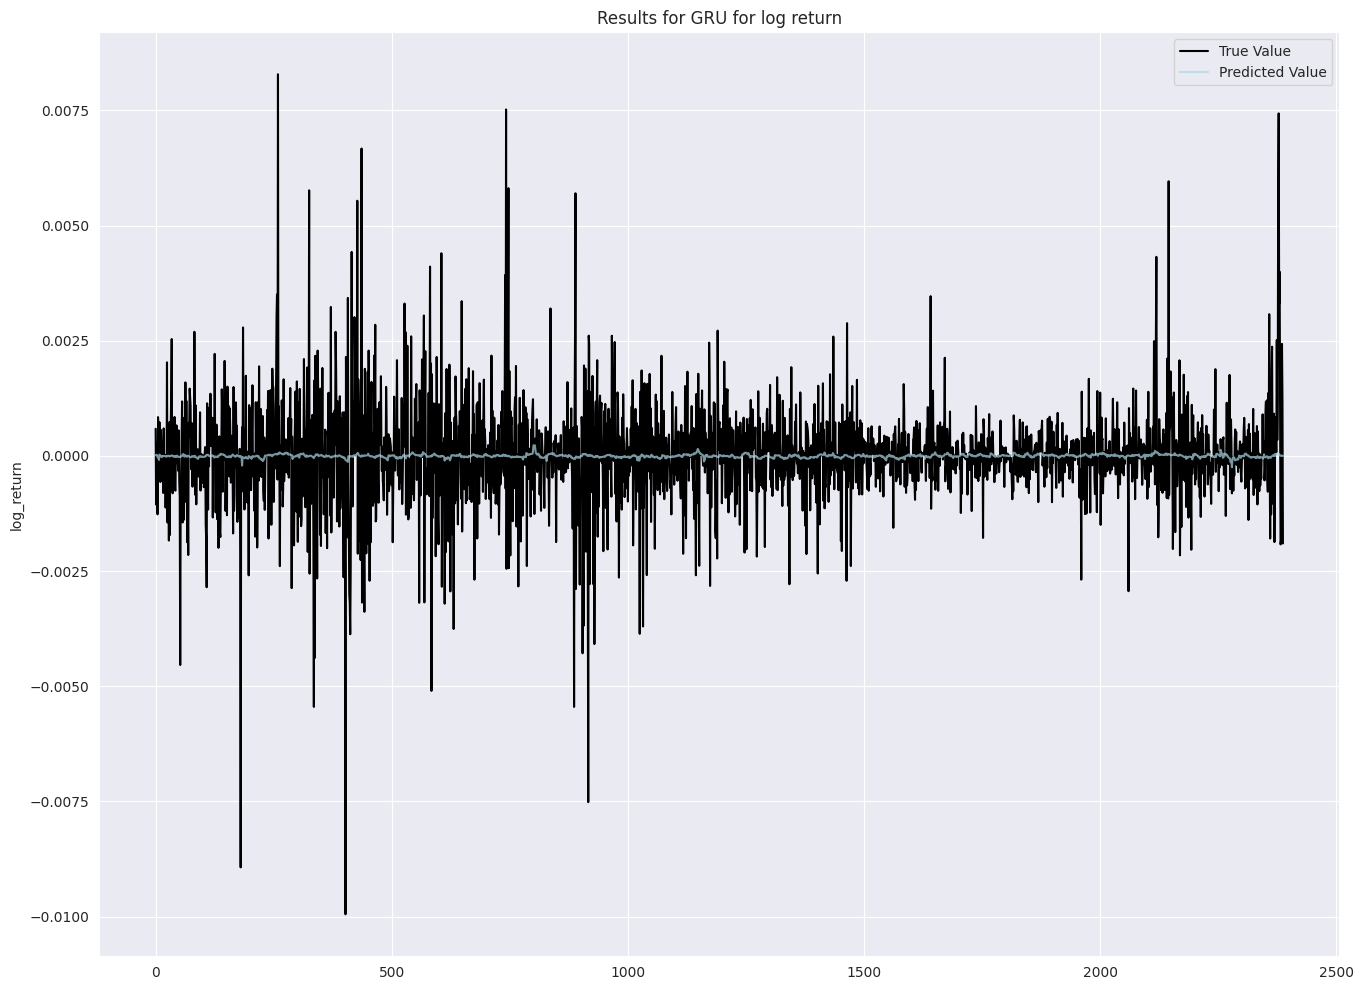

In [24]:
gru.fit(X_train, y_train, n_epochs=30)
clear_output()
results = CountModelResult(X_test, y_test, results, gru, 'GRU for log return')

In [25]:
X_train, X_test, y_train, y_test = SplitData(lookback_data, price, train_fraction=0.99)

#Hyperparameters for sliding window forecasting
fnn = FNNModel(n_layers=2, units=64, n_epochs=25, learning_rate=0.001, dropout=0.1)
gru = GRUModel(n_layers=2, units=32, n_epochs=25, learning_rate=0.0005, dropout=0.1)
lstm = LSTMModel(n_layers=2, units=32, n_epochs=25, learning_rate=0.0009, dropout=0.1)

100%|██████████| 394/394 [08:47<00:00,  1.34s/it]
/tmp/ipykernel_23/2558250014.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for FNN with sliding window for price: 261.787
MAPE for FNN with sliding window for price: 0.642%
MAE for FNN with sliding window for price: 0.006


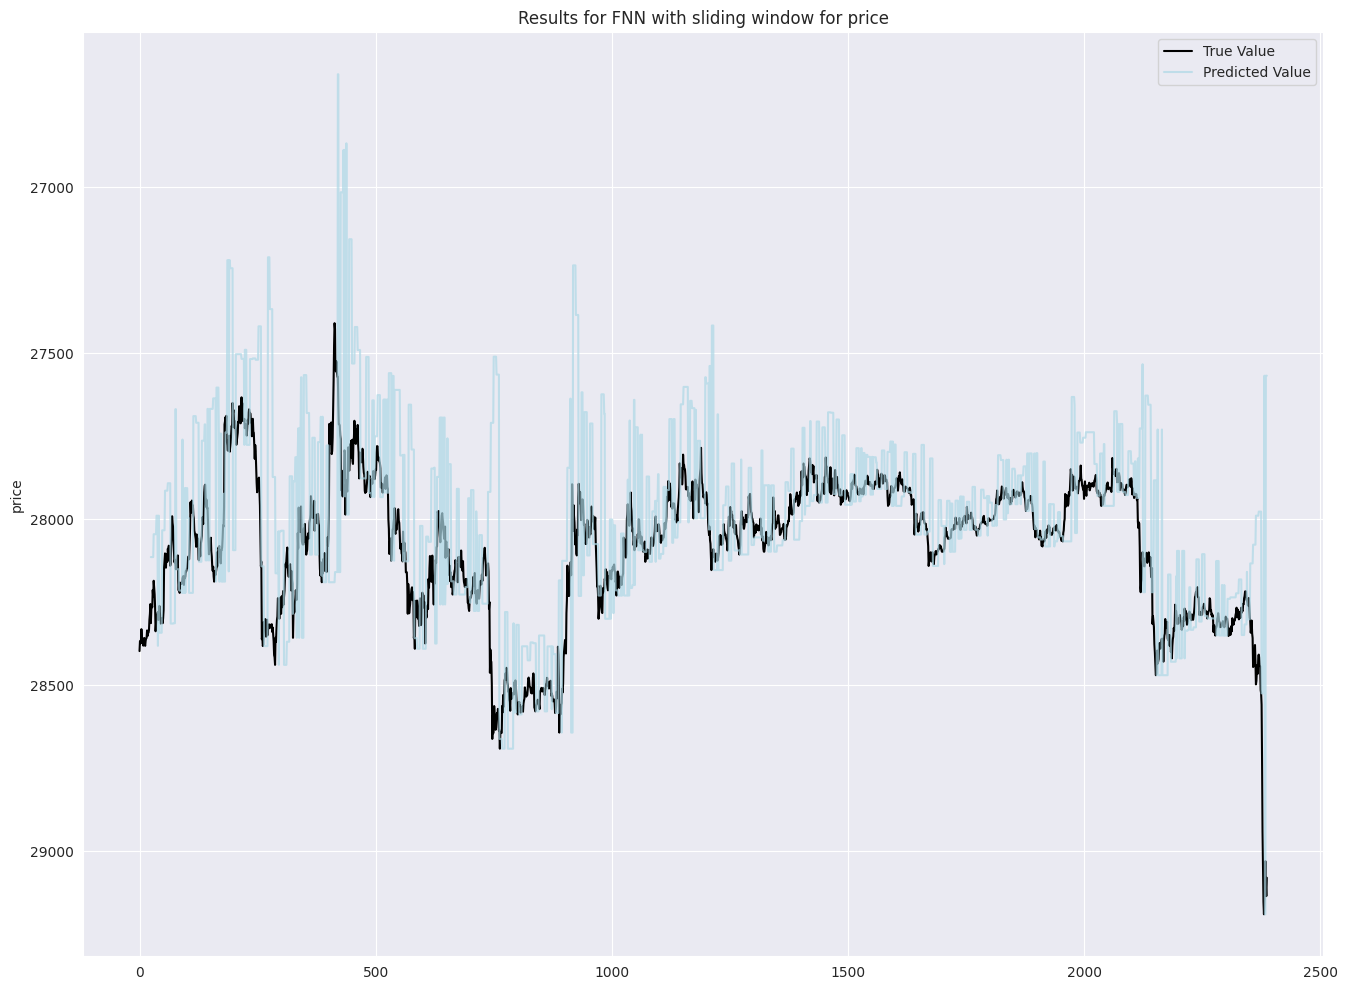

In [26]:
fnn_sw = SlidingWindowForecast().setModel(fnn)
clear_output()
results = CountSlidingWindowResult(X_test, y_test, results, fnn_sw, 'FNN with sliding window for price')

100%|██████████| 394/394 [1:05:32<00:00,  9.98s/it]
/tmp/ipykernel_23/2558250014.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for LSTM with sliding window for price: 82.960
MAPE for LSTM with sliding window for price: 0.188%
MAE for LSTM with sliding window for price: 0.002


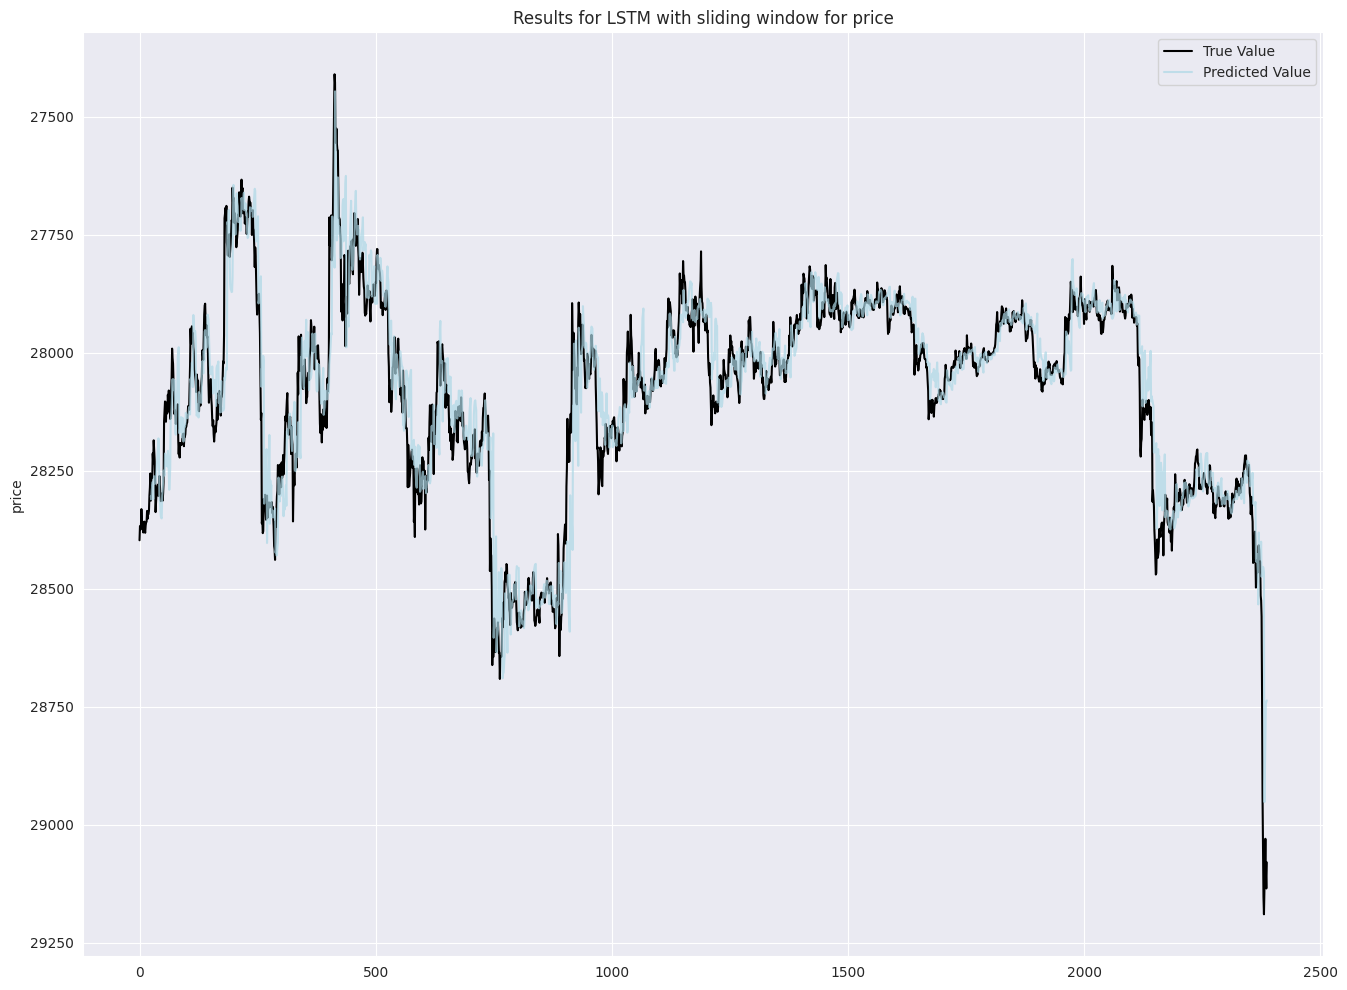

In [27]:
lstm_sw = SlidingWindowForecast().setModel(lstm)
clear_output()
results = CountSlidingWindowResult(X_test, y_test, results, lstm_sw, 'LSTM with sliding window for price')

100%|██████████| 394/394 [1:02:16<00:00,  9.48s/it]
/tmp/ipykernel_23/2558250014.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for GRU with sliding window for price: 106.039
MAPE for GRU with sliding window for price: 0.249%
MAE for GRU with sliding window for price: 0.002


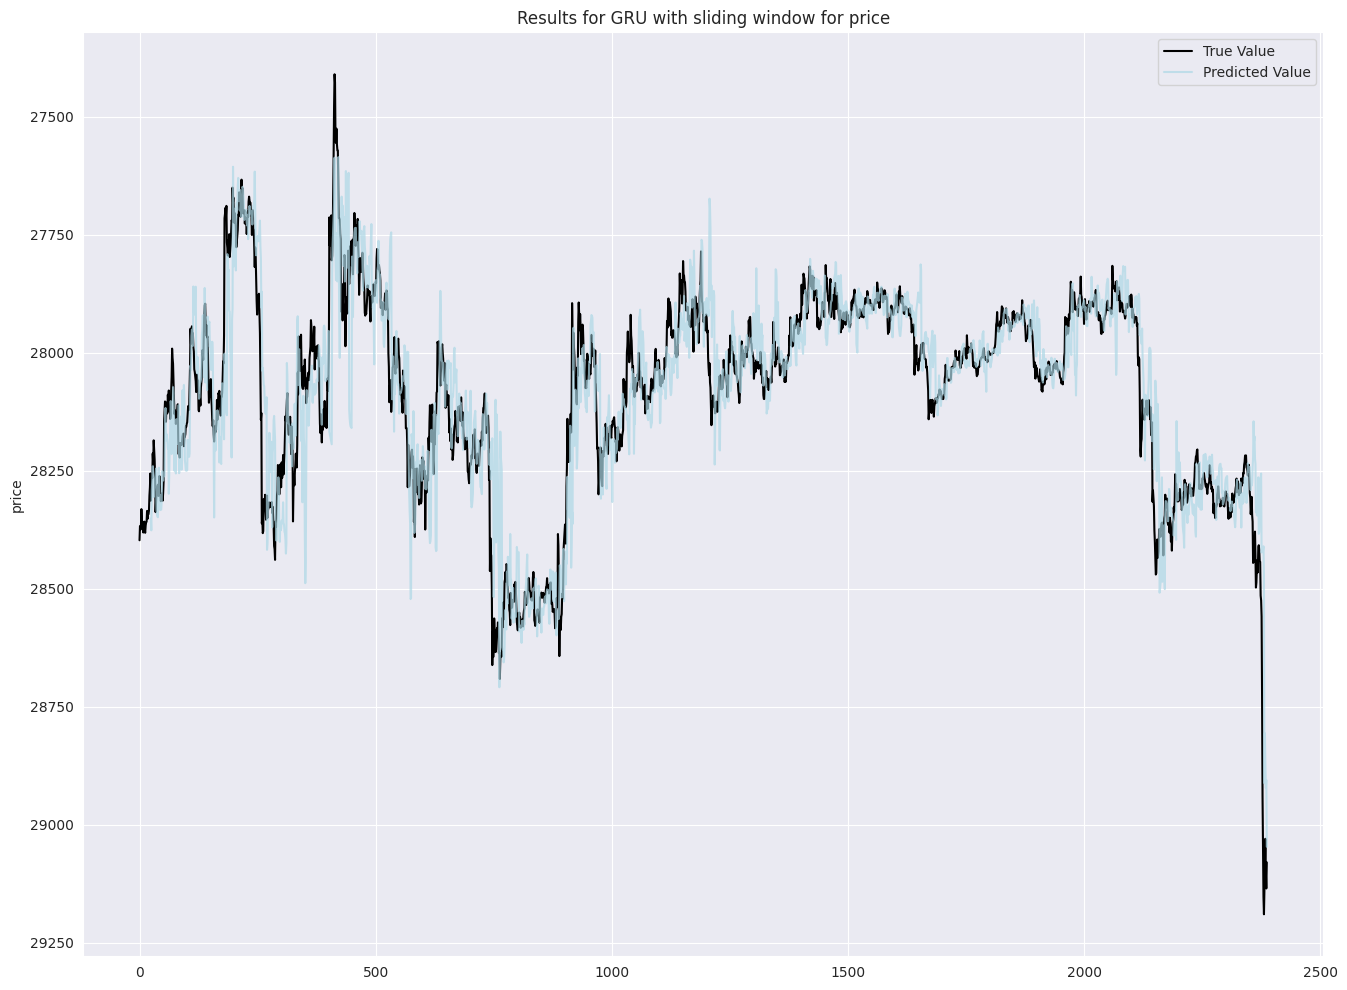

In [28]:
gru_sw = SlidingWindowForecast().setModel(gru)
clear_output()
results = CountSlidingWindowResult(X_test, y_test, results, gru_sw, 'GRU with sliding window for price')

In [29]:
X_train, X_test, y_train, y_test = SplitData(lookback_data, price, train_fraction=0.99)

#Hyperparameters for regular forecasting
fnn = FNNModel(n_layers=3, units=256, n_epochs=100, learning_rate=0.001, dropout=0.25)
gru = GRUModel(n_layers=2, units=128, n_epochs=100, learning_rate=0.0005, dropout=0.25)
lstm = LSTMModel(n_layers=2, units=64, n_epochs=150, learning_rate=0.0009, dropout=0.25)

/tmp/ipykernel_23/1416441513.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for FNN for price: 40664.802
MAPE for FNN for price: 59.190%
MAE for FNN for price: 40661.140


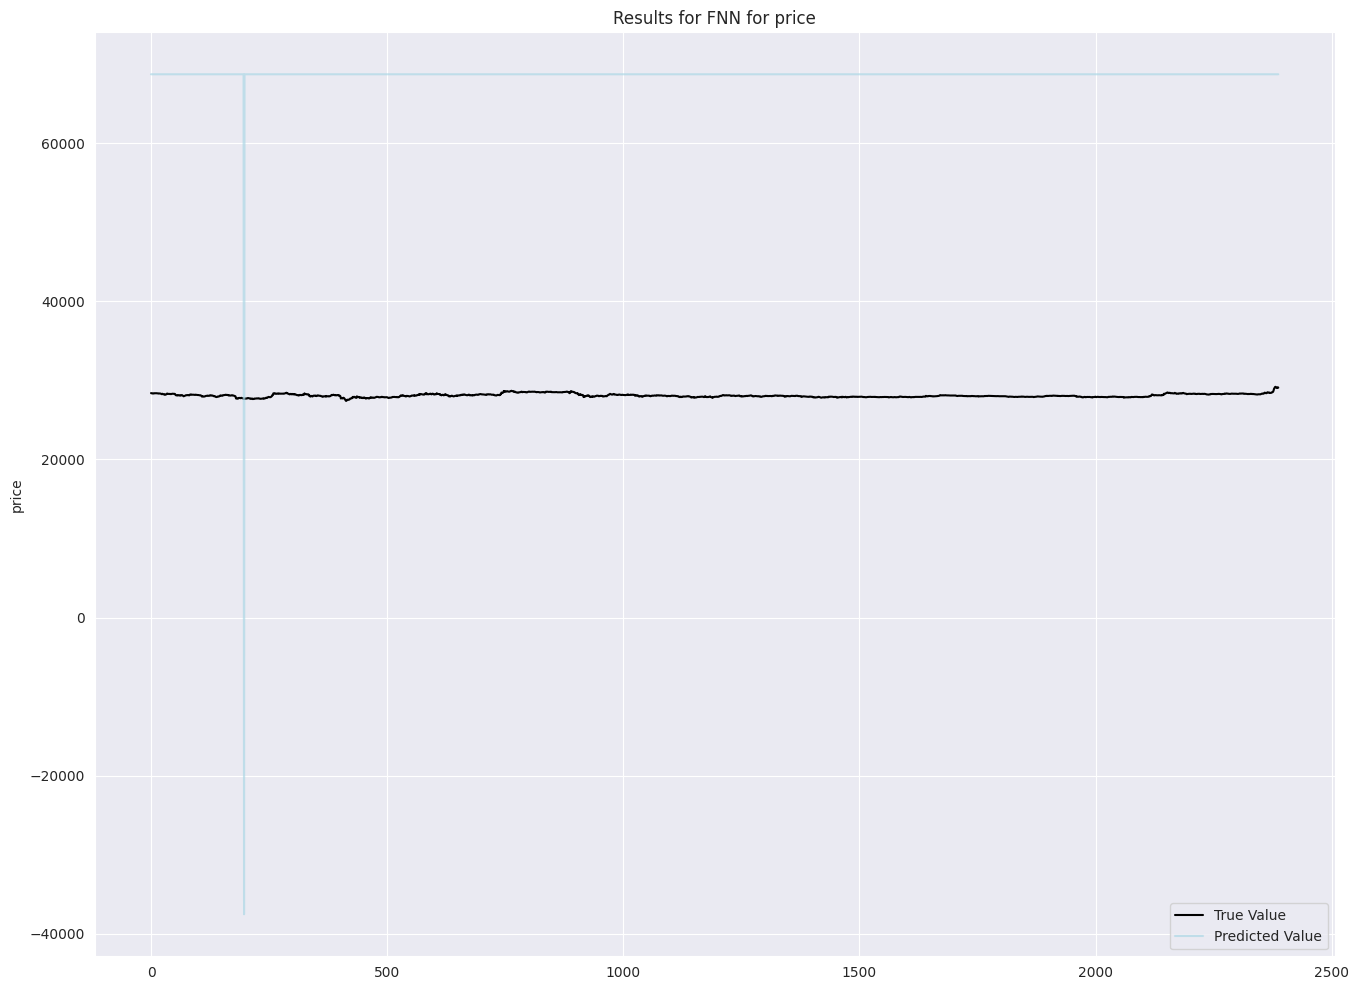

In [30]:
fnn.fit(X_train, y_train)
clear_output()
results = CountModelResult(X_test, y_test, results, fnn, 'FNN for price')

/tmp/ipykernel_23/1416441513.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for LSTM for price: 422.054
MAPE for LSTM for price: 1.326%
MAE for LSTM for price: 377.229


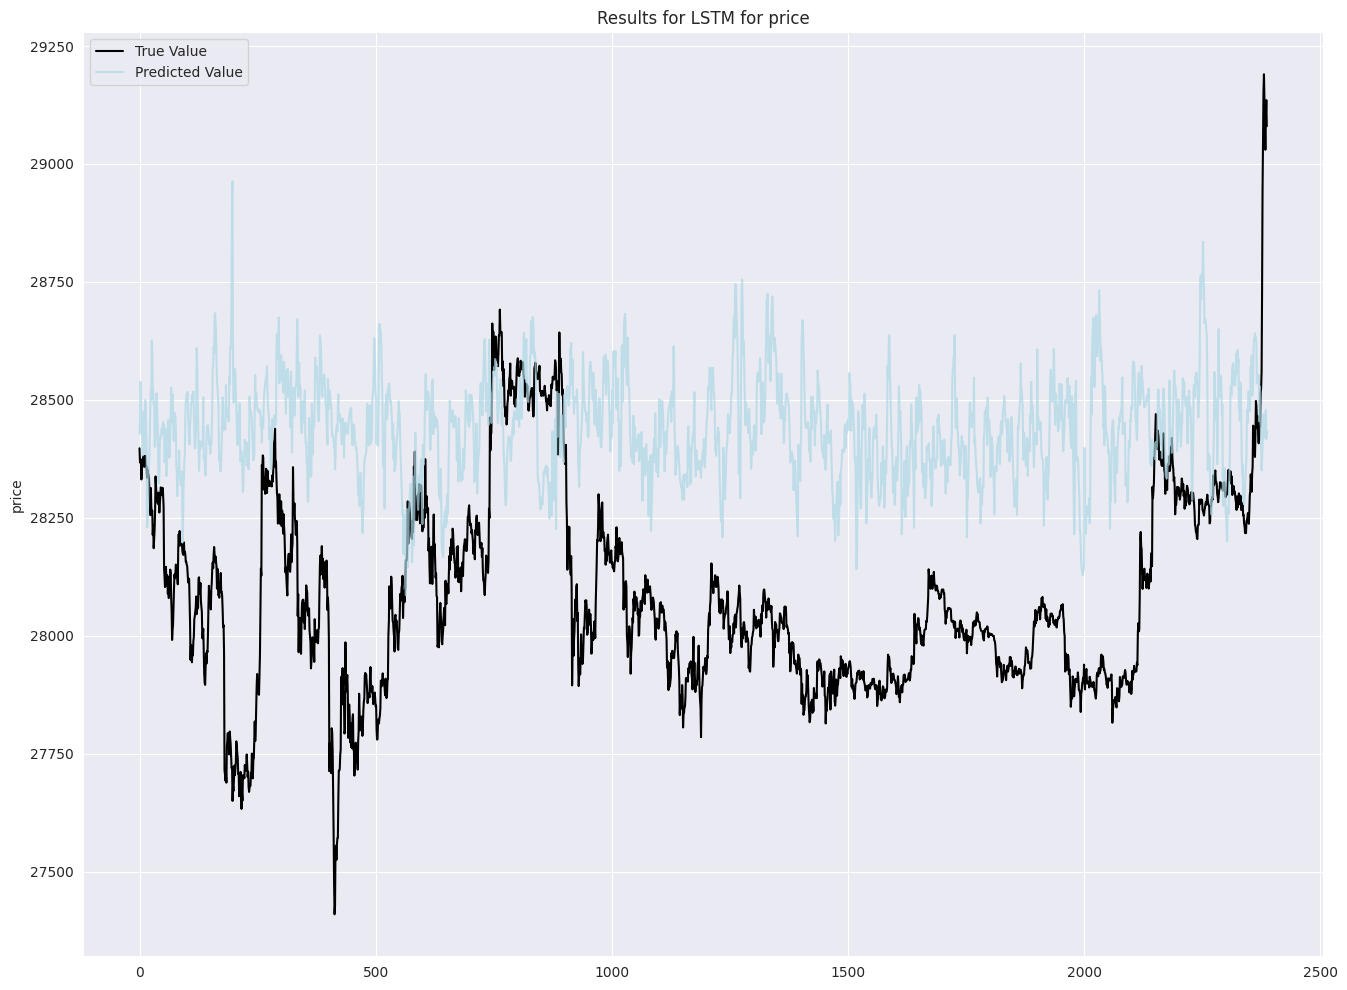

In [31]:
lstm.fit(X_train, y_train)
clear_output()
results = CountModelResult(X_test, y_test, results, lstm, 'LSTM for price')

/tmp/ipykernel_23/1416441513.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for GRU for price: 456.925
MAPE for GRU for price: 1.411%
MAE for GRU for price: 402.159


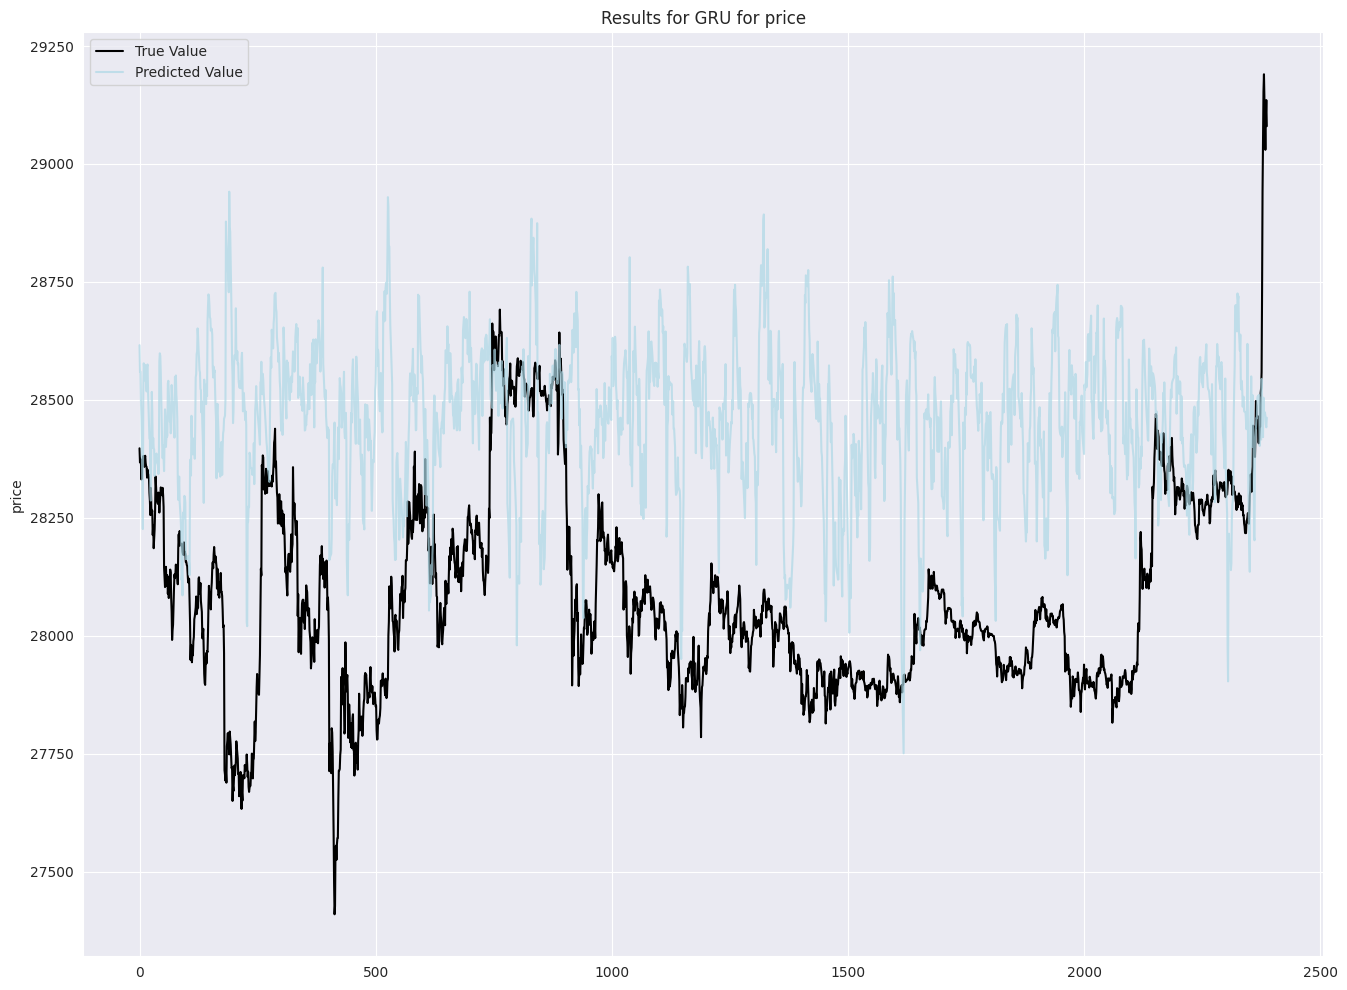

In [32]:
gru.fit(X_train, y_train)
clear_output()
results = CountModelResult(X_test, y_test, results, gru, 'GRU for price')

100%|██████████| 394/394 [1:14:56<00:00, 11.41s/it]
/tmp/ipykernel_23/2558250014.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result)


RMSE for GRU with sliding window for price: 102.693
MAPE for GRU with sliding window for price: 0.232%
MAE for GRU with sliding window for price: 0.002


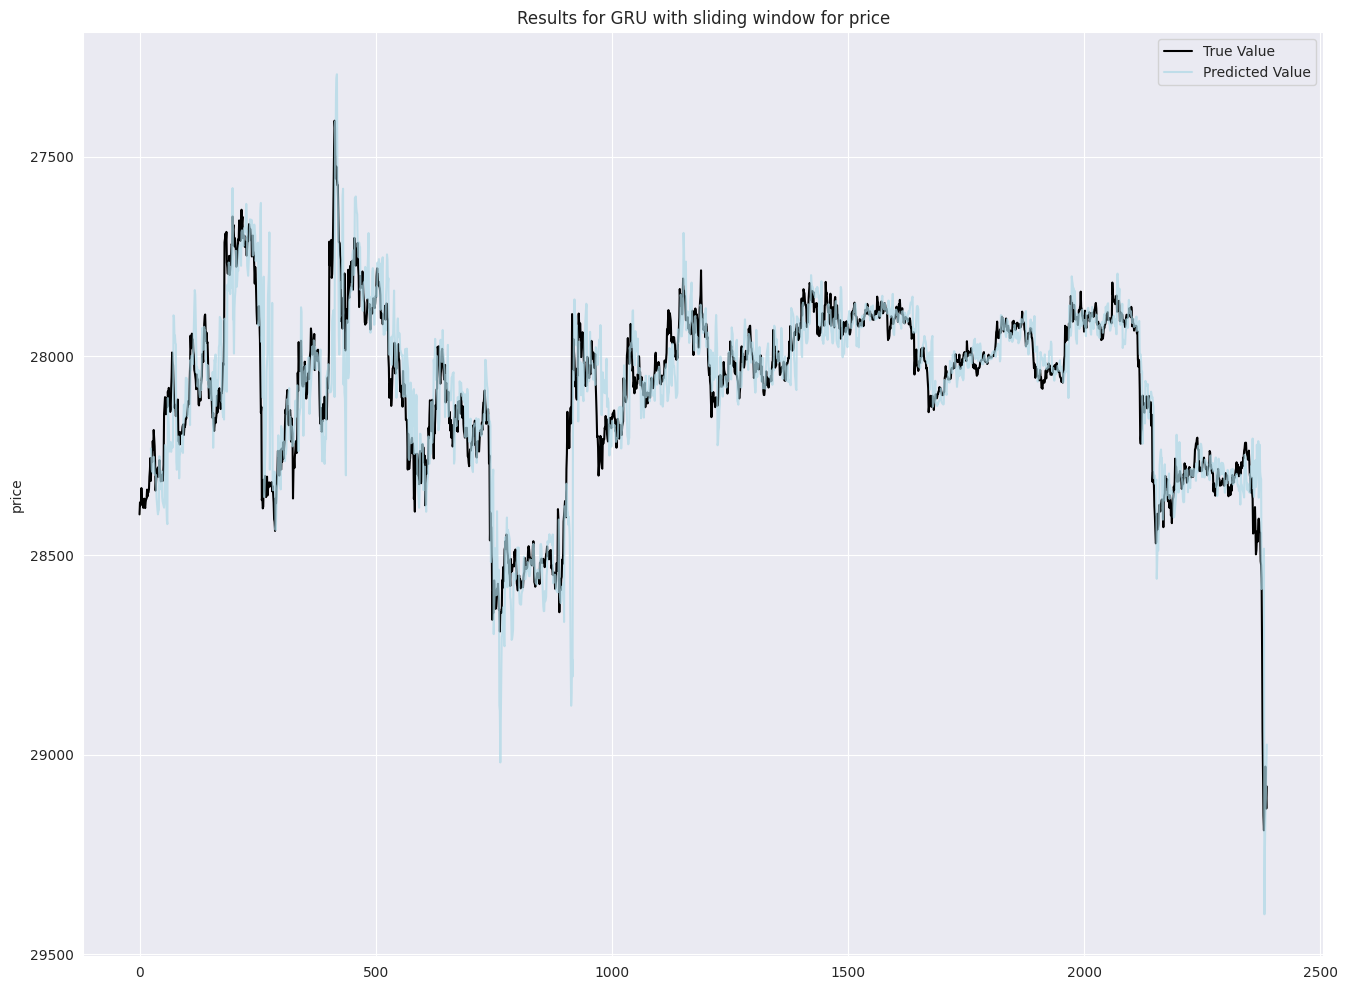

In [33]:
gru_sw = SlidingWindowForecast().setModel(gru)
clear_output()
results = CountSlidingWindowResult(X_test, y_test, results, gru_sw, 'GRU with sliding window for price')